# Bibliotheken importeren

In [1]:
import pandas as pd
import random 
import pyodbc
import sqlite3
import matplotlib.pyplot as plt

# !!! SKLEARN IS DEPRECATED, PIP INSTALL "scikit-learn" INSTEAD !!!
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data inlezen en kolommen selecteren

In [4]:
# !!! HOEFT DIT ALLEEN TE RUNNEN WANNEER DE DATA NOG NIET IN DE SQLITE DATABASE STAAT !!!

DB = {'servername': r'LAPTOP-NBUM6TMN',
    'database': 'johari'}

ssms_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                     ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')
ssms_cursor = ssms_conn.cursor()

# Data inlezen van de benodigde tabellen
returned_item = pd.read_sql("SELECT * FROM RETURNED_ITEM", ssms_conn)
order_details = pd.read_sql("SELECT * FROM ORDERS", ssms_conn)

# Naar SQLite database
sqlite_conn = sqlite3.connect('../data/johari.db')
returned_item.to_sql('RETURNED_ITEM', con=sqlite_conn, if_exists='replace', index=False)
order_details.to_sql('ORDER_DETAILS', con=sqlite_conn, if_exists='replace', index=False)

C:\Users\Jimmy\AppData\Local\Temp\ipykernel_28232\1415686968.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  returned_item = pd.read_sql("SELECT * FROM RETURNED_ITEM", ssms_conn)
C:\Users\Jimmy\AppData\Local\Temp\ipykernel_28232\1415686968.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details = pd.read_sql("SELECT * FROM ORDERS", ssms_conn)


43063

In [3]:
sqlite_conn = sqlite3.connect('../data/johari.db')
df = pd.read_sql('SELECT * FROM RETURNED_ITEM', sqlite_conn)

df = df.loc[:, ['RETURNED_PRODUCT_TYPE_id', 'RETURNED_REASON_description', 'RETURNED_quantity']] # Alleen de benodigde kolommen
df.head()

,RETURNED_PRODUCT_TYPE_id,RETURNED_REASON_description,RETURNED_quantity
0,1,Unsatisfactory product,8
1,1,Incomplete product,2
2,1,Wrong product shipped,22
3,1,Wrong product ordered,20
4,3,Defective product,2


# One-hot encoding van onafhankelijke niet-numerieke variabelen

In [4]:
dummies_dataframe = pd.get_dummies(df.loc[:, ['RETURNED_REASON_description']]) # One-hot encoding
dummies_dataframe.columns = dummies_dataframe.columns.str.replace('RETURNED_REASON_description_', '') # Kolomnamen aanpassen
dummies_dataframe.head()

,Defective product,Incomplete product,Unsatisfactory product,Wrong product ordered,Wrong product shipped
0,False,False,True,False,False
1,False,True,False,False,False
2,False,False,False,False,True
3,False,False,False,True,False
4,True,False,False,False,False


In [5]:
df = pd.concat([df, dummies_dataframe], axis=1) # Dataframes samenvoegen
df = df.drop(columns=['RETURNED_REASON_description']) # Vervangende kolom verwijderen
df = df.loc[:, ['RETURNED_PRODUCT_TYPE_id', 'Defective product', 'Incomplete product', 'Unsatisfactory product', 'Wrong product ordered', 'Wrong product shipped', 'RETURNED_quantity']] # Kolomvolgorde aanpassen
df.head()

,RETURNED_PRODUCT_TYPE_id,Defective product,Incomplete product,Unsatisfactory product,Wrong product ordered,Wrong product shipped,RETURNED_quantity
0,1,False,False,True,False,False,8
1,1,False,True,False,False,False,2
2,1,False,False,False,False,True,22
3,1,False,False,False,True,False,20
4,3,True,False,False,False,False,2


# Verticaal en horizontaal snijden

In [6]:
X = df.drop('RETURNED_quantity', axis=1) # Onafhankelijke variabelen
y = df.loc[:, ['RETURNED_quantity']] # Afhankelijke variabele
X.head()

,RETURNED_PRODUCT_TYPE_id,Defective product,Incomplete product,Unsatisfactory product,Wrong product ordered,Wrong product shipped
0,1,False,False,True,False,False
1,1,False,True,False,False,False
2,1,False,False,False,False,True
3,1,False,False,False,True,False
4,3,True,False,False,False,False


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42
) # Data splitsen in trainings- en testset

# Regressiemodel bouwen

In [8]:
reg_model = linear_model.LinearRegression() # Regressiemodel
reg_model = LinearRegression().fit(X_train, y_train) # Model trainen
reg_model

LinearRegression()

In [9]:
y_pred = reg_model.predict(X_test) # Voorspellingen maken
y_pred

array([[ 5.91879249],
       [ 1.80083873],
       [ 2.83494189],
       [32.39591087],
       [48.68137028],
       [ 1.80083873],
       [ 1.28378715],
       [47.13021554],
       [28.25949822],
       [52.30073135],
       [ 2.83494189],
       [46.61316396],
       [ 6.95289565],
       [ 2.816483  ],
       [63.81829806],
       [ 7.48840612],
       [ 5.42019979],
       [43.51085447],
       [ 2.816483  ],
       [ 4.88468933],
       [ 6.97135454],
       [46.09611238],
       [ 5.93725138],
       [61.75009174],
       [ 6.43584407],
       [ 6.45430296],
       [ 1.80083873],
       [ 1.78237984],
       [64.85240122],
       [ 7.48840612],
       [36.01527193],
       [ 4.88468933],
       [ 6.97135454],
       [ 3.86904505],
       [44.02790605],
       [50.7495766 ],
       [ 7.48840612],
       [49.71547344],
       [ 0.2312251 ],
       [37.56642668],
       [ 4.88468933],
       [29.29360138],
       [ 4.88468933],
       [59.68188541],
       [ 4.88468933],
       [63

In [10]:
prediction_df = pd.DataFrame(y_pred) # Voorspellingen in dataframe zetten
prediction_df = prediction_df.rename(columns={0: 'Predicted_Return_Quantity'}) # Kolomnaam aanpassen
prediction_df.head()

,Predicted_Return_Quantity
0,5.918792
1,1.800839
2,2.834942
3,32.395911
4,48.681370


In [11]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['RETURNED_quantity'], prediction_df], axis=1) # Voorspellingen en echte waarden samenvoegen
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_Return_Quantity'].notna(), :] # Alleen de voorspellingen tonen
y_test_prediction_merge.head()

,RETURNED_quantity,Predicted_Return_Quantity
0,4,5.918792
1,2,1.800839
2,2,2.834942
3,70,32.395911
4,8,48.681370


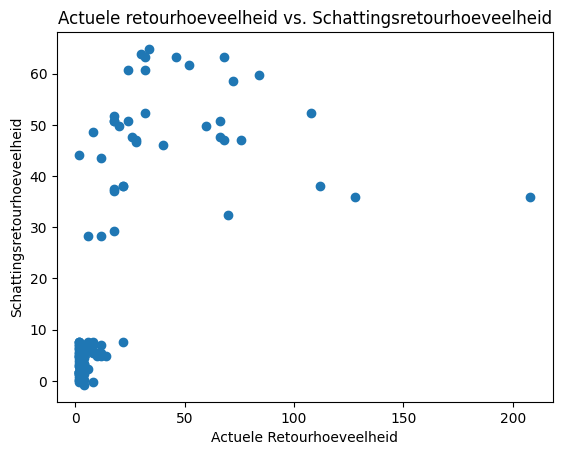

In [12]:
plt.scatter(y_test_prediction_merge['RETURNED_quantity'], y_test_prediction_merge['Predicted_Return_Quantity']) # Scatterplot
plt.xlabel('Actuele Retourhoeveelheid')
plt.ylabel('Schattingsretourhoeveelheid')
plt.title('Actuele retourhoeveelheid vs. Schattingsretourhoeveelheid')
plt.show()

In [13]:
mean_squared_error(y_test, y_pred) # Mean Squared Error, lager is beter

664.0962345601708

In [14]:
mean_absolute_error(y_test, y_pred) # Mean Absolute Error, lager is beter

13.326079252843229